In [130]:
import numpy as np
import matplotlib.pyplot as plt

In [131]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
def data_load():
    response_file_path = '/content/drive/MyDrive/Sparse_PUFs/train_responses.dat'
    challenge_file_path = '/content/drive/MyDrive/Sparse_PUFs/train_challenges.dat'
    response_file = open(response_file_path, "r")
    response_data = list(response_file.read().split("\n"))
    response_values = []
    for value in response_data:
        if value:
            x = float(value)
            response_values.append(x)

    challenge_file = open(challenge_file_path, "r")
    challenge_data = list(challenge_file.read().split("\n"))
    challenge_values = []
    for line in challenge_data:
        challenge_line = []
        if line:
            parts = line.split(" ")
            for part in parts:
                if part.isdigit():
                    challenge_line.append(part)
        else:
            continue
        challenge_values.append(challenge_line)

    return np.asarray(challenge_values, dtype=float), np.asarray(response_values)


In [133]:
challenges, responses = data_load()
# responses

In [134]:
def train_test_split(data, targets, test_size, random_state=None):
    np.random.seed(random_state)
    num_samples = len(data)
    num_test_samples = int(num_samples * test_size)
    shuffled_indices = np.random.permutation(num_samples)

    train_indices = shuffled_indices[:-num_test_samples]
    test_indices = shuffled_indices[-num_test_samples:]

    X_train = data[train_indices]
    y_train = targets[train_indices]
    X_test = data[test_indices]
    y_test = targets[test_indices]

    return X_train, X_test, y_train, y_test


In [135]:

X_train, X_val, y_train, y_val = train_test_split(challenges, responses, test_size=0.2, random_state=42)
y_train.shape


(1280,)

In [136]:
def gradient(w, X, y):
    n = X.shape[0]
    diff = X.dot(w) - y.reshape(-1)
    grad = X.T.dot(diff) / n
    return grad

In [137]:
def projected_gradient_descent(X, y, learning_rate, max_iterations, regularization_lambda, momentum_factor):
    n, d = X.shape
    w = np.zeros(d)
    momentum = np.zeros(d)
    costs = []
    iterations = []
    iteration = 0
    loss = 1
    threshold_loss = 0.019862317617946088

    while loss > threshold_loss and iteration < max_iterations:
        grad = gradient(w, X, y)

        momentum = momentum * momentum_factor + learning_rate * grad  # Update momentum with Nesterov factor
        w_new = w - momentum

        # Define the file path where you want to save the weights
        file_path = "weights.txt"

        # Write the weights to the text file
        with open(file_path, "w") as file:
            for weight in w_new:
                file.write(str(weight) + "\n")

        # Apply non-negativity constraint
        w_new = np.maximum(0, w_new)

        # Compute the loss with regularization
        loss = (np.linalg.norm(X.dot(w_new) - y) ** 2 + regularization_lambda * np.linalg.norm(w_new) ** 2) / (2 * n)
        costs.append(loss)
        iterations.append(iteration)
        iteration += 1

        print(f"Iteration: {iteration}, Loss: {loss}")

        if np.allclose(w, w_new):
            break

        w = w_new

    # Plotting the cost vs. iterations with two y-axes (logarithmic for first 450 iterations, linear for the rest)
    fig, ax1 = plt.subplots()

    ax1.plot(iterations, costs, label="Cost (Log Scale)", color="b")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Cost (Log Scale)", color="b")
    ax1.set_yscale("log")
    ax1.tick_params(axis='y', labelcolor="b")
    plt.title("Cost vs. Iterations")
    fig.tight_layout()
    plt.show()

    return w

Iteration: 1, Loss: 5028273.225665509
Iteration: 2, Loss: 23166.109745807007
Iteration: 3, Loss: 2060461.148205032
Iteration: 4, Loss: 32180.470891744248
Iteration: 5, Loss: 2295960.375577987
Iteration: 6, Loss: 501668.2462893279
Iteration: 7, Loss: 1201775.2066947757
Iteration: 8, Loss: 1760170.693581013
Iteration: 9, Loss: 108719.78022231584
Iteration: 10, Loss: 1810168.8279005631
Iteration: 11, Loss: 93070.3900786383
Iteration: 12, Loss: 1348032.1815246874
Iteration: 13, Loss: 922148.4638350963
Iteration: 14, Loss: 362922.24883512914
Iteration: 15, Loss: 1673993.8560271868
Iteration: 16, Loss: 24376.247412592507
Iteration: 17, Loss: 1112728.8446246115
Iteration: 18, Loss: 374230.0592996914
Iteration: 19, Loss: 483116.39112143207
Iteration: 20, Loss: 838532.2819312091
Iteration: 21, Loss: 63483.39193715914
Iteration: 22, Loss: 1098926.9463912188
Iteration: 23, Loss: 125763.7904417904
Iteration: 24, Loss: 509602.4121531087
Iteration: 25, Loss: 403549.4619431933
Iteration: 26, Loss: 11

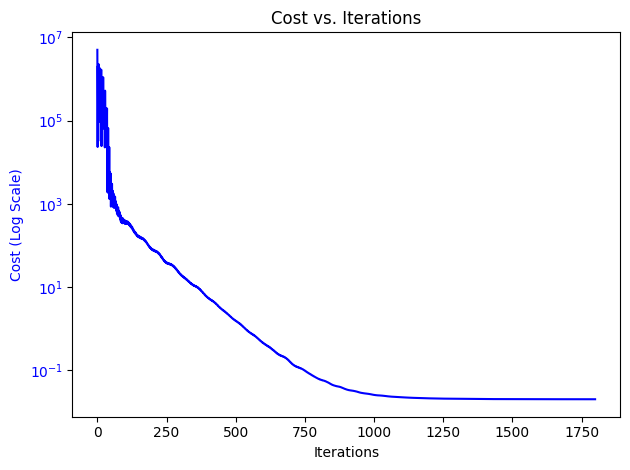

Final weights:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.52859225e+00
 9.70427040e-04 0.00000000e+00]
Weights saved to /content/drive/MyDrive/Sparse_PUFs/PGD_weights.txt


In [138]:
learning_rate = 0.005
max_iterations = 1800
momentum_factor = 0.99 # Value between 0 and 1 for momentum acceleration
regularization_lambda = 0.001
# Perform projected gradient descent with momentum
weights = projected_gradient_descent(X_train, y_train, learning_rate, max_iterations, regularization_lambda, momentum_factor)

print("Final weights:")
print(weights)
output_path = '/content/drive/MyDrive/Sparse_PUFs/PGD_weights.txt'
np.savetxt(output_path, weights)

print(f"Weights saved to {output_path}")

In [139]:
y_pred = X_val.dot(weights)
mse = np.mean((y_pred - y_val) ** 2)
print(f"Test MSE: {mse}")

Test MSE: 0.003325423605563496


In [140]:
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2


In [141]:
# Assuming you have the true target values (y_true), predicted target values (y_pred), and weights (weights)

# Calculate the predicted target values
y_pred = X_val.dot(weights)

# Calculate the R-squared metric
r_square = r_squared(y_val, y_pred)

print(f"r_square: {r_square}")


r_square: 0.9999997307947304
